In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('pre_funding_startup_dataset_200.csv')
df.head()

,Startup Name,Industry,Revenue (USD),Revenue Growth (%),Monthly Active Users,User Growth Rate (%),CAC (USD),LTV (USD),Burn Rate (USD/month),Cash Runway (months),TAM (USD),Team Size,Funding Stage,Valuation (USD)
0,Startup001,SaaS,4128731,149,87681,17,241,3074,332428,6,81946269312,39,Seed,24466368
1,Startup002,Greentech,2428312,115,143691,18,490,2464,96519,24,71223892797,37,Pre-Seed,96641650
2,Startup003,Greentech,1478230,32,156520,7,165,849,996255,24,25765873614,97,Series A,38460951
3,Startup004,Healthtech,7815497,190,434808,39,380,2641,340129,15,8777057441,37,Series A,56139309
4,Startup005,Fintech,1102665,88,260269,10,179,7657,731477,18,39626814884,83,Pre-Seed,14977950


In [ ]:
#Preprocess Dataset
# LTV - CAC ratio
df['LTV_CAC_Ratio'] = df['LTV (USD)'] / df['CAC (USD)']
df.loc[df['LTV_CAC_Ratio'] < 3, 'LTV (USD)'] *= 1.5
# Burn Rate per month
burn_caps = {'Pre-Seed': 200000, 'Seed': 500000, 'Series A': 1000000}
df['Burn Rate (USD/month)'] = df.apply(
    lambda row: min(row['Burn Rate (USD/month)'], burn_caps[row['Funding Stage']]), axis=1
)
# Team size
team_ranges = {'Pre-Seed': (5, 15), 'Seed': (10, 30), 'Series A': (20, 50)}
df['Team Size'] = df.apply(
    lambda row: min(max(row['Team Size'], team_ranges[row['Funding Stage']][0]),
                    team_ranges[row['Funding Stage']][1]), axis=1
)
# Cap extreme values in features to prevent outliers
df['Revenue (USD)'] = df['Revenue (USD)'].clip(upper=10000000)  # Cap at $10M
df['Monthly Active Users'] = df['Monthly Active Users'].clip(upper=500000)  # Cap at 500K
df['Revenue Growth (%)'] = df['Revenue Growth (%)'].clip(upper=200)  # Cap at 200%
df['TAM (USD)'] = df['TAM (USD)'].clip(upper=100000000000)  # Cap at $100B

# Recompute Valuation with caps to prevent extreme values
industry_multipliers = {'SaaS': (5, 10), 'Fintech': (4, 8), 'Healthtech': (3, 7),
                           'Greentech': (2, 5), 'E-commerce': (2, 6), 'Edtech': (3,7)}
df['Base_Valuation'] = df.apply(
        lambda row: row['Revenue (USD)'] * np.random.uniform(*industry_multipliers[row['Industry']]),
        axis=1
    ).clip(upper=100000000)  # Cap at $100M
df['Growth_Bonus'] = (df['Revenue Growth (%)'] * 100000).clip(upper=20000000)  # Cap at $20M
df['User_Bonus'] = (df['Monthly Active Users'] * 50).clip(upper=25000000)  # Cap at $25M
#df['Valuation (USD)'] = (df['Base_Valuation'] + df['Growth_Bonus'] + df['User_Bonus']).astype(int)
df["Valuation (USD)"] = pd.to_numeric(df["Valuation (USD)"], errors="coerce")

# Debug: Check valuation distribution
print("Valuation (USD) Summary Statistics:")
print(df['Valuation (USD)'].describe())
print("\nTop 5 Valuations:")
print(df['Valuation (USD)'].nlargest(5))
# Save updated dataset
df.to_csv('startup_data_updated.csv', index=False)


Valuation (USD) Summary Statistics:
count    2.000000e+02
mean     4.848189e+07
std      2.779688e+07
min      1.323606e+06
25%      2.574795e+07
50%      4.607362e+07
75%      7.125256e+07
max      9.940510e+07
Name: Valuation (USD), dtype: float64

Top 5 Valuations:
187    99405095
15     98896036
102    97996018
1      96641650
61     95558905
Name: Valuation (USD), dtype: int64


<ipython-input-3-31d4f263223a>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 774.   949.5 1792.5 1027.5 1105.5 1233.  1015.5  856.5 1498.5  826.5
 1750.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['LTV_CAC_Ratio'] < 3, 'LTV (USD)'] *= 1.5


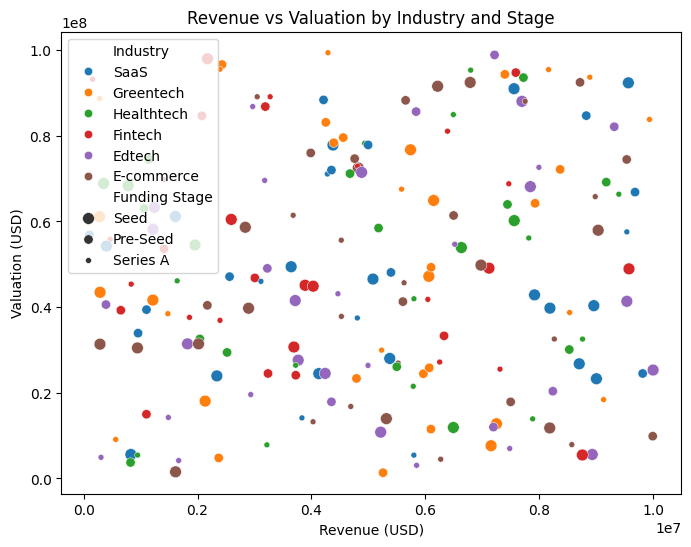

In [ ]:
# Reviewing updated dataset
df = pd.read_csv('startup_data_updated.csv')
df['LTV_CAC_Ratio'] = df['LTV (USD)'] / df['CAC (USD)']
df['Revenue_per_User'] = df['Revenue (USD)'] / df['Monthly Active Users']
df['Burn_to_Revenue'] = df['Burn Rate (USD/month)'] * 12 / df['Revenue (USD)']
# Scatter plot: Revenue vs Valuation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Revenue (USD)', y='Valuation (USD)', hue='Industry', size='Funding Stage', data=df)
plt.title('Revenue vs Valuation by Industry and Stage')
plt.show()

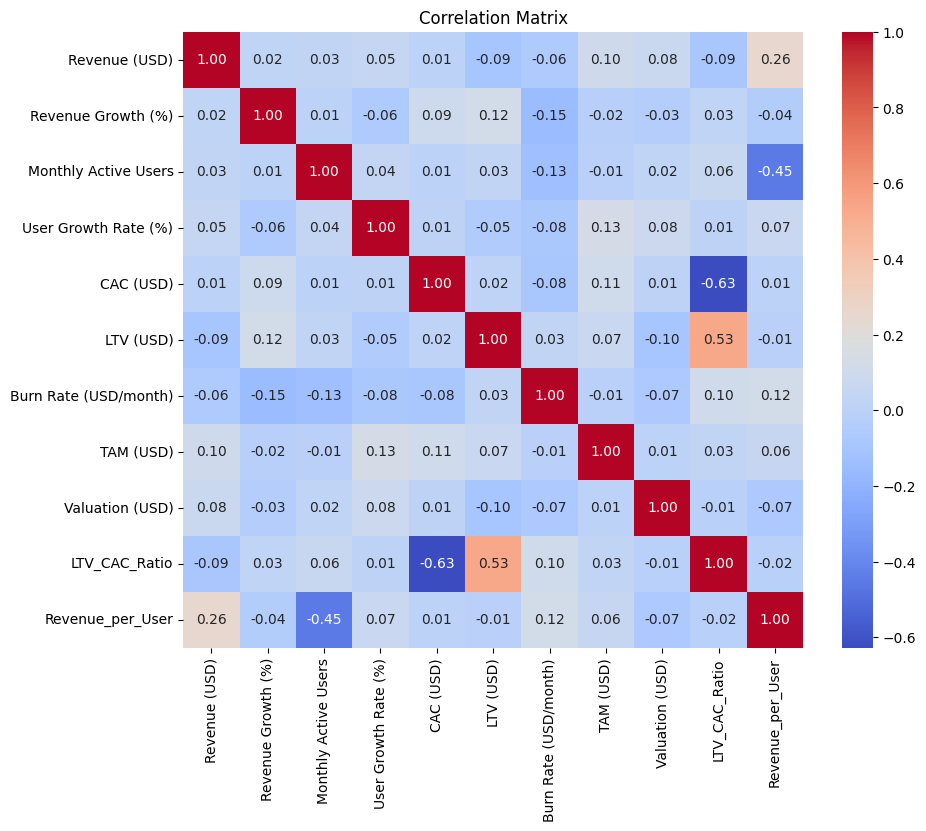

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = ['Revenue (USD)', 'Revenue Growth (%)', 'Monthly Active Users',
                    'User Growth Rate (%)', 'CAC (USD)', 'LTV (USD)',
                    'Burn Rate (USD/month)', 'TAM (USD)', 'Valuation (USD)',
                    'LTV_CAC_Ratio', 'Revenue_per_User']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

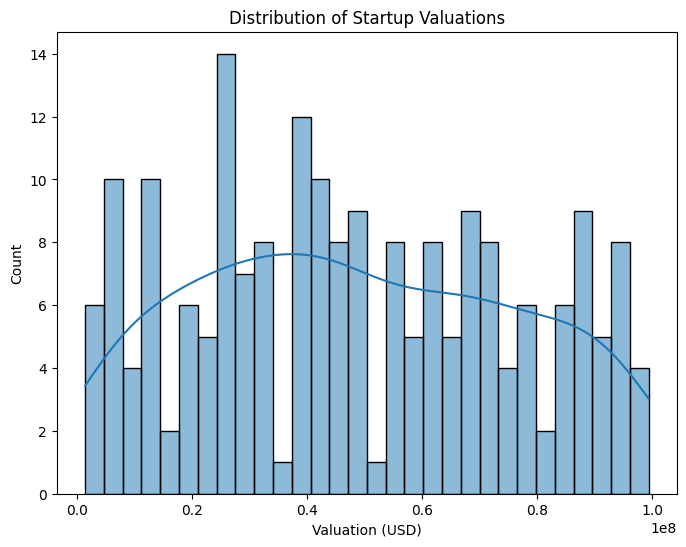

In [ ]:
# Distribution of Valuations
plt.figure(figsize=(8, 6))
sns.histplot(df['Valuation (USD)'], bins=30, kde=True)
plt.title('Distribution of Startup Valuations')
plt.show()

Correlation with Valuation (USD):
Valuation (USD)               1.000000
Revenue (USD)                 0.806251
Revenue_Growth_Interaction    0.689701
Monthly Active Users          0.357827
Revenue Growth (%)            0.268000
TAM (USD)                     0.107455
Revenue_per_User              0.083693
LTV_CAC_Ratio                -0.091667
Name: Valuation (USD), dtype: float64
Linear Regression RMSE (dollar scale): $3,508,247.33
MAPE: 7.99%
R² Score: 0.96

Sample Predicted vs Actual Valuations (dollar scale):
Predicted: $41,781,435.04, Actual: $45,207,688.00
Predicted: $69,761,603.50, Actual: $71,823,825.00
Predicted: $21,999,930.40, Actual: $24,789,045.00
Predicted: $72,419,282.22, Actual: $69,049,760.00
Predicted: $39,710,116.07, Actual: $39,022,618.00

Cross-Validation R² Scores: [0.93549229 0.95968055 0.94913889 0.94849927 0.94972778]
Average CV R² Score: 0.95 ± 0.01


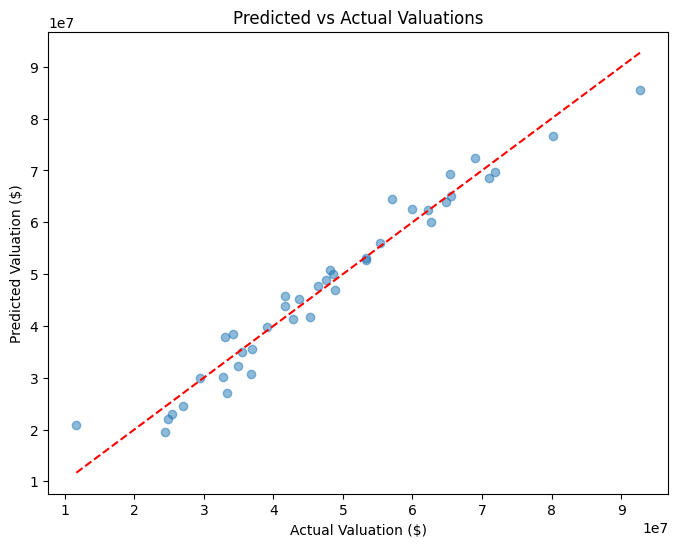

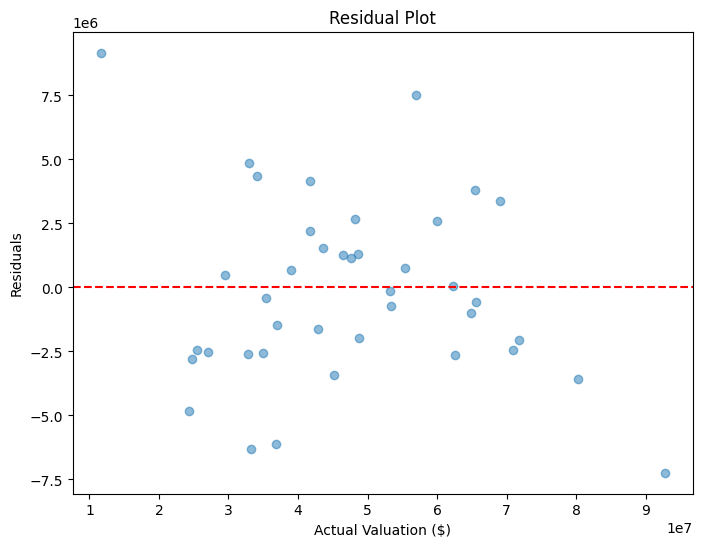

In [ ]:
# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load dataset
df = pd.read_csv('startup_data_updated.csv')

# Data Cleaning
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df['LTV (USD)'] = df['LTV (USD)'].astype(float)
df['Valuation (USD)'] = df['Valuation (USD)'].astype(float)

# Recompute Valuation with a deterministic formula
industry_multipliers = {'SaaS': 7.5, 'Fintech': 6, 'Healthtech': 5, 'Greentech': 3.5, 'E-commerce': 4, 'Edtech': 5}
df['Valuation (USD)'] = df.apply(
    lambda row: row['Revenue (USD)'] * industry_multipliers[row['Industry']] +
                (row['Revenue Growth (%)'] * 100000) + (row['Monthly Active Users'] * 50),
    axis=1
).clip(upper=100000000)

# Feature Engineering
df['LTV_CAC_Ratio'] = df['LTV (USD)'] / df['CAC (USD)']
df.loc[df['LTV_CAC_Ratio'] < 3, 'LTV (USD)'] *= 1.5
df['LTV_CAC_Ratio'] = df['LTV (USD)'] / df['CAC (USD)']
df['Revenue_per_User'] = df['Revenue (USD)'] / df['Monthly Active Users']
df['Revenue_Growth_Interaction'] = df['Revenue (USD)'] * df['Revenue Growth (%)']
df['LTV_CAC_Ratio'] = df['LTV_CAC_Ratio'].clip(upper=df['LTV_CAC_Ratio'].quantile(0.95))

# Cap extreme values (no log transform)
df['Revenue (USD)'] = df['Revenue (USD)'].clip(upper=10000000)
df['Monthly Active Users'] = df['Monthly Active Users'].clip(upper=500000)
df['Revenue Growth (%)'] = df['Revenue Growth (%)'].clip(upper=200)
df['TAM (USD)'] = df['TAM (USD)'].clip(upper=100000000000)

# Feature Selection
numeric_features = ['Revenue (USD)', 'Monthly Active Users', 'Revenue Growth (%)',
                    'TAM (USD)', 'LTV_CAC_Ratio', 'Revenue_per_User',
                    'Revenue_Growth_Interaction']
categorical_features = ['Industry', 'Funding Stage']

# Correlation Analysis
print("Correlation with Valuation (USD):")
print(df[numeric_features + ['Valuation (USD)']].corr()['Valuation (USD)'].sort_values(ascending=False))

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Define features and target
X = df[numeric_features + categorical_features]
y = df['Valuation (USD)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
model = LinearRegression()

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate model
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE (dollar scale): ${rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.2f}")

# Sample predictions
print("\nSample Predicted vs Actual Valuations (dollar scale):")
for pred, actual in list(zip(y_pred[:5], y_test[:5])):
    print(f"Predicted: ${pred:,.2f}, Actual: ${actual:,.2f}")

# Cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Average CV R² Score: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Valuation ($)')
plt.ylabel('Predicted Valuation ($)')
plt.title('Predicted vs Actual Valuations')
plt.show()

# Residual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred - y_test, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Valuation ($)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Save updated dataset
df.to_csv('startup_data_preprocessed_v5.csv', index=False)

In [ ]:
# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load dataset
df = pd.read_csv('startup_data_updated.csv')

# Data Cleaning
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df['LTV (USD)'] = df['LTV (USD)'].astype(float)
df['Valuation (USD)'] = df['Valuation (USD)'].astype(float)

# Recompute Valuation with deterministic formula
industry_multipliers = {'SaaS': 7.5, 'Fintech': 6, 'Healthtech': 5, 'Greentech': 3.5, 'E-commerce': 4, 'Edtech': 5}
df['Valuation (USD)'] = df.apply(
    lambda row: row['Revenue (USD)'] * industry_multipliers[row['Industry']] +
                (row['Revenue Growth (%)'] * 100000) + (row['Monthly Active Users'] * 50),
    axis=1
).clip(upper=100000000)

# Feature Engineering
df['LTV_CAC_Ratio'] = df['LTV (USD)'] / df['CAC (USD)']
df.loc[df['LTV_CAC_Ratio'] < 3, 'LTV (USD)'] *= 1.5
df['LTV_CAC_Ratio'] = df['LTV (USD)'] / df['CAC (USD)']
df['Revenue_per_User'] = df['Revenue (USD)'] / df['Monthly Active Users']
df['Revenue_Growth_Interaction'] = df['Revenue (USD)'] * df['Revenue Growth (%)']
df['LTV_CAC_Ratio'] = df['LTV_CAC_Ratio'].clip(upper=df['LTV_CAC_Ratio'].quantile(0.95))

# Add non-linear transformations and interactions
df['Revenue_Squared'] = df['Revenue (USD)'] ** 2
df['Growth_Squared'] = df['Revenue Growth (%)'] ** 2
df['LTV_Growth_Interaction'] = df['LTV_CAC_Ratio'] * df['Revenue Growth (%)']

# Cap extreme values
df['Revenue (USD)'] = df['Revenue (USD)'].clip(upper=10000000)
df['Monthly Active Users'] = df['Monthly Active Users'].clip(upper=500000)
df['Revenue Growth (%)'] = df['Revenue Growth (%)'].clip(upper=200)
df['TAM (USD)'] = df['TAM (USD)'].clip(upper=100000000000)
df['Revenue_Squared'] = df['Revenue_Squared'].clip(upper=(10000000 ** 2))
df['Growth_Squared'] = df['Growth_Squared'].clip(upper=(200 ** 2))

# Feature Selection
numeric_features = ['Revenue (USD)', 'Monthly Active Users', 'Revenue Growth (%)',
                    'TAM (USD)', 'LTV_CAC_Ratio', 'Revenue_per_User',
                    'Revenue_Growth_Interaction', 'Revenue_Squared',
                    'Growth_Squared', 'LTV_Growth_Interaction']
categorical_features = ['Industry', 'Funding Stage']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Define features and target
X = df[numeric_features + categorical_features]
y = df['Valuation (USD)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model with Grid Search
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate model
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE (dollar scale): ${rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.2f}")

# Sample predictions
print("\nSample Predicted vs Actual Valuations (dollar scale):")
for pred, actual in list(zip(y_pred[:5], y_test[:5])):
    print(f"Predicted: ${pred:,.2f}, Actual: ${actual:,.2f}")

# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"\nCross-Validation R² Scores: {cv_scores}")
print(f"Average CV R² Score: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Feature Importance
feature_names = (numeric_features +
                 list(best_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))
importance = best_model.named_steps['regressor'].feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Save updated dataset
df.to_csv('startup_data_preprocessed_v6.csv', index=False)

Best Hyperparameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}
XGBoost RMSE (dollar scale): $4,710,622.54
MAPE: 9.03%
R² Score: 0.92

Sample Predicted vs Actual Valuations (dollar scale):
Predicted: $45,720,916.00, Actual: $45,207,688.00
Predicted: $69,629,008.00, Actual: $71,823,825.00
Predicted: $24,865,768.00, Actual: $24,789,045.00
Predicted: $69,775,192.00, Actual: $69,049,760.00
Predicted: $38,736,876.00, Actual: $39,022,618.00

Cross-Validation R² Scores: [0.97165583 0.93998196 0.95313341 0.92213466 0.94478922]
Average CV R² Score: 0.95 ± 0.02

Feature Importance:
                       Feature  Importance
14               Industry_SaaS    0.230833
0                Revenue (USD)    0.226875
6   Revenue_Growth_Interaction    0.218086
7              Revenue_Squared    0.123224
12          Industry_Greentech    0.070863
1         Monthly Active Users    0.055512
2   

Performance Metrics Comparison:
               Model  R² Score          RMSE      MAPE
0  Linear Regression  0.956411  3.552619e+06  7.837670
1            XGBoost  0.934513  4.354484e+06  8.149107


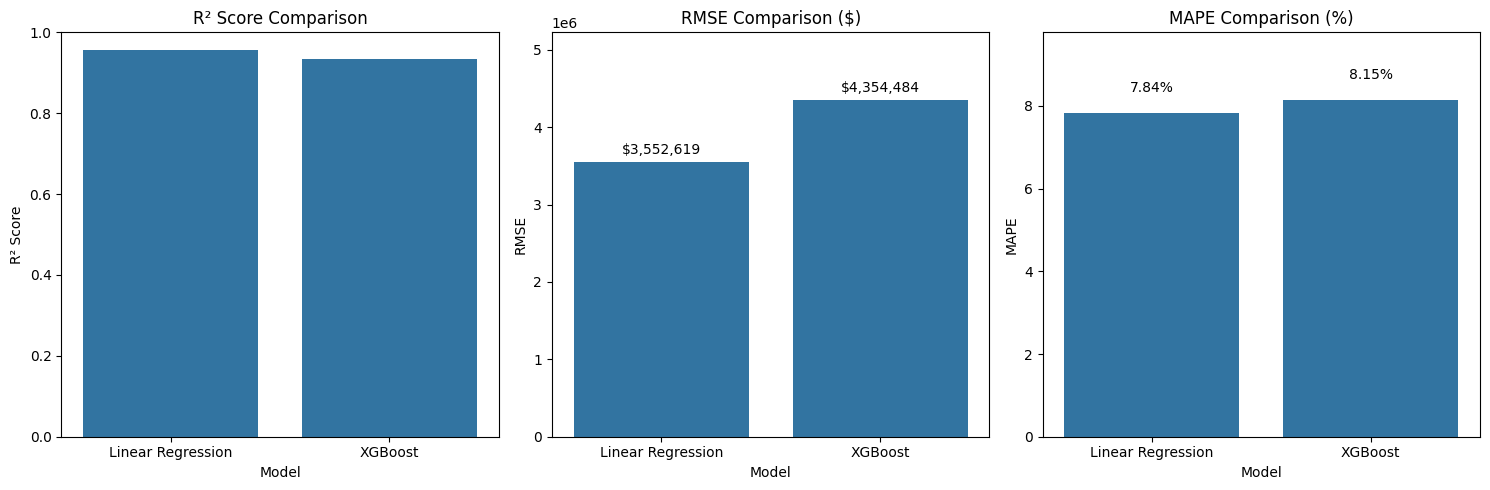

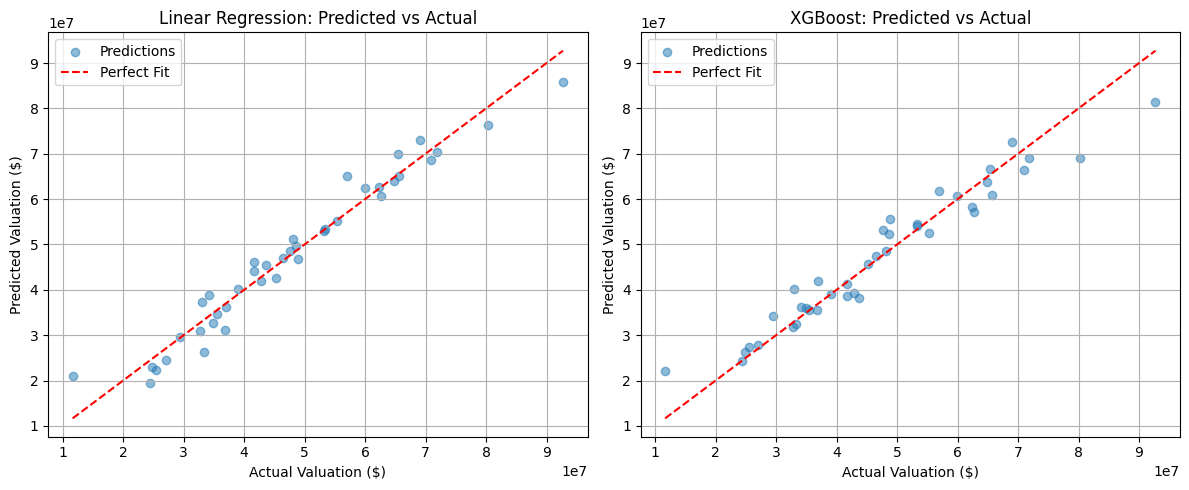

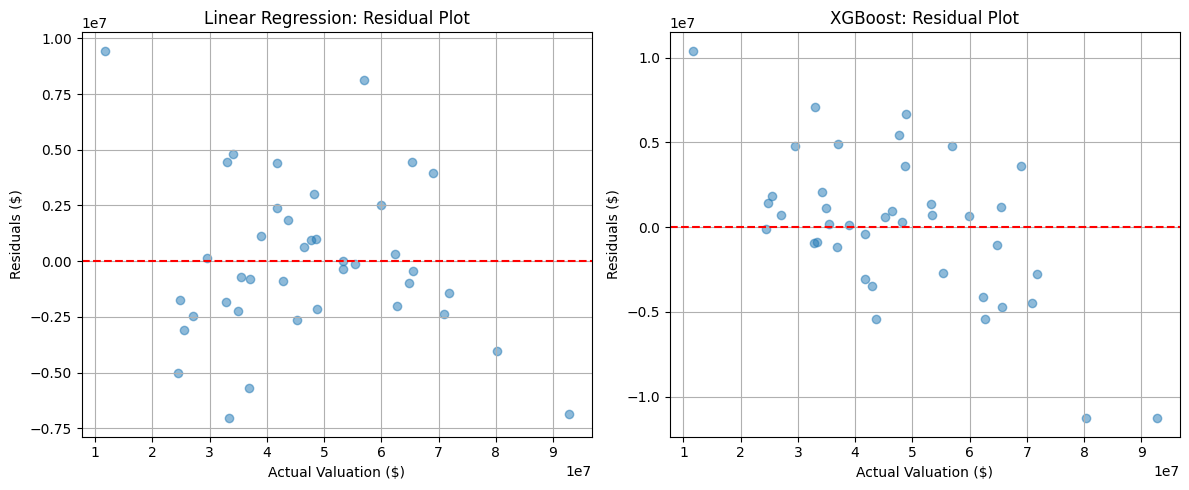

In [ ]:
# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load dataset
df = pd.read_csv('startup_data_updated.csv')

# Data Cleaning
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df['LTV (USD)'] = df['LTV (USD)'].astype(float)
df['Valuation (USD)'] = df['Valuation (USD)'].astype(float)

# Recompute Valuation with deterministic formula
industry_multipliers = {'SaaS': 7.5, 'Fintech': 6, 'Healthtech': 5, 'Greentech': 3.5, 'E-commerce': 4, 'Edtech': 5}
df['Valuation (USD)'] = df.apply(
    lambda row: row['Revenue (USD)'] * industry_multipliers[row['Industry']] +
                (row['Revenue Growth (%)'] * 100000) + (row['Monthly Active Users'] * 50),
    axis=1
).clip(upper=100000000)

# Feature Engineering (using the latest feature set)
df['Revenue_per_User'] = df['Revenue (USD)'] / df['Monthly Active Users']
df['Revenue_Growth_Interaction'] = df['Revenue (USD)'] * df['Revenue Growth (%)']
df['Revenue_Squared'] = df['Revenue (USD)'] ** 2

# Cap extreme values
df['Revenue (USD)'] = df['Revenue (USD)'].clip(upper=10000000)
df['Monthly Active Users'] = df['Monthly Active Users'].clip(upper=500000)
df['Revenue Growth (%)'] = df['Revenue Growth (%)'].clip(upper=200)
df['Revenue_Squared'] = df['Revenue_Squared'].clip(upper=(10000000 ** 2))

# Feature Selection
numeric_features = ['Revenue (USD)', 'Monthly Active Users', 'Revenue Growth (%)',
                    'Revenue_per_User', 'Revenue_Growth_Interaction', 'Revenue_Squared']
categorical_features = ['Industry', 'Funding Stage']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Define features and target
X = df[numeric_features + categorical_features]
y = df['Valuation (USD)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', lr_model)
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# XGBoost Model (using the best hyperparameters from your last run)
xgb_model = xgb.XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=300,
    subsample=0.8
)
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
# Compute metrics for both models
metrics = {
    'Model': ['Linear Regression', 'XGBoost'],
    'R² Score': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_xgb)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    ],
    'MAPE': [
        mean_absolute_percentage_error(y_test, y_pred_lr),
        mean_absolute_percentage_error(y_test, y_pred_xgb)
    ]
}
metrics_df = pd.DataFrame(metrics)

# Print metrics
print("Performance Metrics Comparison:")
print(metrics_df)

# 1. Bar Plot for Performance Metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² Score
sns.barplot(x='Model', y='R² Score', data=metrics_df, ax=axes[0])
axes[0].set_title('R² Score Comparison')
axes[0].set_ylim(0, 1)

# RMSE
sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=axes[1])
axes[1].set_title('RMSE Comparison ($)')
axes[1].set_ylim(0, max(metrics_df['RMSE']) * 1.2)
for i, v in enumerate(metrics_df['RMSE']):
    axes[1].text(i, v + 100000, f'${v:,.0f}', ha='center')

# MAPE
sns.barplot(x='Model', y='MAPE', data=metrics_df, ax=axes[2])
axes[2].set_title('MAPE Comparison (%)')
axes[2].set_ylim(0, max(metrics_df['MAPE']) * 1.2)
for i, v in enumerate(metrics_df['MAPE']):
    axes[2].text(i, v + 0.5, f'{v:.2f}%', ha='center')

plt.tight_layout()
plt.show()

# 2. Predicted vs Actual Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear Regression
axes[0].scatter(y_test, y_pred_lr, alpha=0.5, label='Predictions')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
axes[0].set_xlabel('Actual Valuation ($)')
axes[0].set_ylabel('Predicted Valuation ($)')
axes[0].set_title('Linear Regression: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True)

# XGBoost
axes[1].scatter(y_test, y_pred_xgb, alpha=0.5, label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
axes[1].set_xlabel('Actual Valuation ($)')
axes[1].set_ylabel('Predicted Valuation ($)')
axes[1].set_title('XGBoost: Predicted vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 3. Residual Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear Regression
axes[0].scatter(y_test, y_pred_lr - y_test, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Actual Valuation ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title('Linear Regression: Residual Plot')
axes[0].grid(True)

# XGBoost
axes[1].scatter(y_test, y_pred_xgb - y_test, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Actual Valuation ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('XGBoost: Residual Plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Example of saving a file in Colab
code = ""
import tkinter as tk
from tkinter import messagebox

def predict():
    # Placeholder for model prediction
    result = "Predicted valuation: $5M"
    messagebox.showinfo("Result", result)

root = tk.Tk()
root.title("Startup Valuation Predictor")

label = tk.Label(root, text="Enter features:")
label.pack()

entry = tk.Entry(root)
entry.pack()

btn = tk.Button(root, text="Predict", command=predict)
btn.pack()

root.mainloop()
"""

with open("startup_gui.py", "w") as f:
    f.write(code)


SyntaxError: incomplete input (<ipython-input-37-d93a04733910>, line 24)

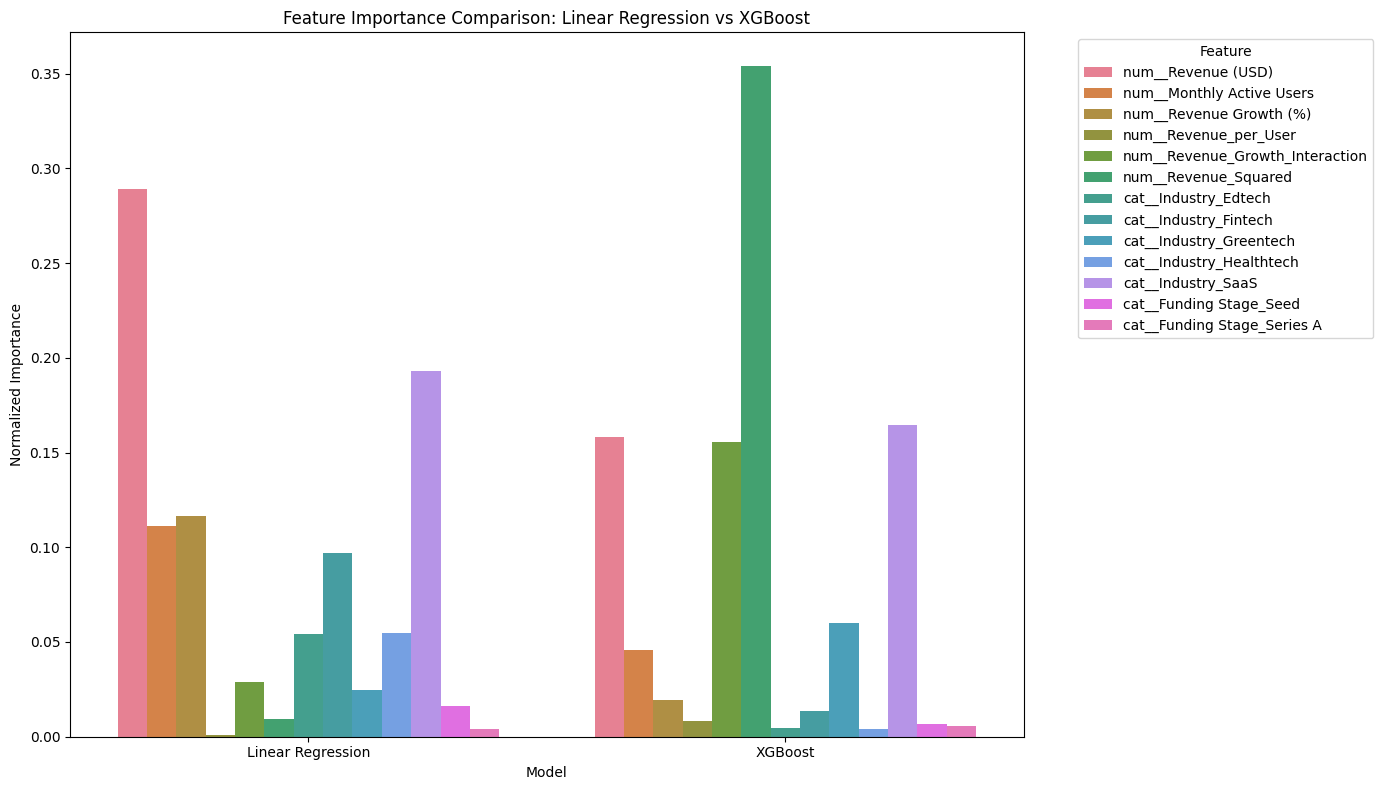


Linear Regression Feature Importance (Normalized Coefficients):
                            Feature  Importance
0                num__Revenue (USD)    0.289202
10               cat__Industry_SaaS    0.193275
2           num__Revenue Growth (%)    0.116726
1         num__Monthly Active Users    0.111120
7             cat__Industry_Fintech    0.097038
9          cat__Industry_Healthtech    0.054693
6              cat__Industry_Edtech    0.054115
4   num__Revenue_Growth_Interaction    0.028701
8           cat__Industry_Greentech    0.024806
11          cat__Funding Stage_Seed    0.015978
5              num__Revenue_Squared    0.009108
12      cat__Funding Stage_Series A    0.004219
3             num__Revenue_per_User    0.001019

XGBoost Feature Importance:
                            Feature  Importance
5              num__Revenue_Squared    0.354061
10               cat__Industry_SaaS    0.164534
0                num__Revenue (USD)    0.157956
4   num__Revenue_Growth_Interaction    0.1

In [ ]:
# Assuming the models (lr_pipeline, xgb_pipeline), X, and feature_names are already defined
# Extract feature names after preprocessing
feature_names = (numeric_features +
                 list(lr_pipeline.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

# Linear Regression: Use normalized absolute coefficients as feature importance
lr_coefs = lr_pipeline.named_steps['regressor'].coef_
lr_abs_coefs = np.abs(lr_coefs)
lr_importance_normalized = lr_abs_coefs / lr_abs_coefs.sum()  # Normalize to sum to 1

# Get the feature names from the preprocessor for Linear Regression
lr_feature_names = lr_pipeline.named_steps['preprocessor'].get_feature_names_out()

lr_importance = pd.DataFrame({
    'Feature': lr_feature_names,  # Use lr_feature_names here
    'Importance': lr_importance_normalized,
    'Model': 'Linear Regression'
})

# XGBoost: Use built-in feature importance
xgb_importance_values = xgb_pipeline.named_steps['regressor'].feature_importances_

# Get the feature names from the preprocessor for XGBoost
xgb_feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

xgb_importance = pd.DataFrame({
    'Feature': xgb_feature_names,  # Use xgb_feature_names here
    'Importance': xgb_importance_values,
    'Model': 'XGBoost'
})

# Combine the two dataframes
combined_importance = pd.concat([lr_importance, xgb_importance], ignore_index=True)

# Plot Feature Importance (Side-by-Side Bar Plot)
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Importance', hue='Feature', data=combined_importance)
plt.title('Feature Importance Comparison: Linear Regression vs XGBoost')
plt.xlabel('Model')
plt.ylabel('Normalized Importance')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print the importance values for reference
print("\nLinear Regression Feature Importance (Normalized Coefficients):")
print(lr_importance[['Feature', 'Importance']].sort_values(by='Importance', ascending=False))
print("\nXGBoost Feature Importance:")
print(xgb_importance[['Feature', 'Importance']].sort_values(by='Importance', ascending=False))

In [ ]:
!pip install nest-asyncio
import nest_asyncio
nest_asyncio.apply()
import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
!apt-get install -y xvfb # Install virtual display server
!pip install pyvirtualdisplay # Install pyvirtualdisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 600))
display.start()
import tkinter as tk

class StartupValuationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Startup Valuation Predictor")
        self.root.geometry("1200x800")
        self.root.resizable(True, True)

        # Set the color scheme
        self.bg_color = "#f5f5f5"
        self.accent_color = "#4a86e8"
        self.text_color = "#333333"
        self.root.configure(bg=self.bg_color)

        # Initialize model
        self.model = None
        self.preprocessor = None
        self.numeric_features = ['Revenue (USD)', 'Monthly Active Users', 'Revenue Growth (%)',
                                'Revenue_per_User', 'Revenue_Growth_Interaction', 'Revenue_Squared']
        self.categorical_features = ['Industry', 'Funding Stage']

        # Industry options
        self.industry_options = ['SaaS', 'Fintech', 'Healthtech', 'Greentech', 'E-commerce', 'Edtech']

        # Funding stage options
        self.funding_options = ['Pre-seed', 'Seed', 'Series A', 'Series B']

        # Create UI
        self.create_ui()

        # Load and train model
        self.load_and_train_model()

    def create_ui(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding=20)
        main_frame.pack(fill=tk.BOTH, expand=True)

        # Left panel - Input
        input_frame = ttk.LabelFrame(main_frame, text="Startup Information", padding=10)
        input_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=(0, 10))

        # Right panel - Output
        output_frame = ttk.LabelFrame(main_frame, text="Valuation Results", padding=10)
        output_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=(10, 0))

        # Input fields
        input_inner_frame = ttk.Frame(input_frame, padding=5)
        input_inner_frame.pack(fill=tk.BOTH, expand=True)

        # Revenue
        ttk.Label(input_inner_frame, text="Revenue (USD):").grid(row=0, column=0, sticky=tk.W, pady=5)
        self.revenue_var = tk.StringVar()
        ttk.Entry(input_inner_frame, textvariable=self.revenue_var).grid(row=0, column=1, sticky=tk.W+tk.E, pady=5)

        # Monthly Active Users
        ttk.Label(input_inner_frame, text="Monthly Active Users:").grid(row=1, column=0, sticky=tk.W, pady=5)
        self.mau_var = tk.StringVar()
        ttk.Entry(input_inner_frame, textvariable=self.mau_var).grid(row=1, column=1, sticky=tk.W+tk.E, pady=5)

        # Revenue Growth
        ttk.Label(input_inner_frame, text="Revenue Growth (%):").grid(row=2, column=0, sticky=tk.W, pady=5)
        self.growth_var = tk.StringVar()
        ttk.Entry(input_inner_frame, textvariable=self.growth_var).grid(row=2, column=1, sticky=tk.W+tk.E, pady=5)

        # Industry
        ttk.Label(input_inner_frame, text="Industry:").grid(row=3, column=0, sticky=tk.W, pady=5)
        self.industry_var = tk.StringVar()
        industry_combo = ttk.Combobox(input_inner_frame, textvariable=self.industry_var, values=self.industry_options)
        industry_combo.grid(row=3, column=1, sticky=tk.W+tk.E, pady=5)
        industry_combo.current(0)

        # Funding Stage
        ttk.Label(input_inner_frame, text="Funding Stage:").grid(row=4, column=0, sticky=tk.W, pady=5)
        self.funding_var = tk.StringVar()
        funding_combo = ttk.Combobox(input_inner_frame, textvariable=self.funding_var, values=self.funding_options)
        funding_combo.grid(row=4, column=1, sticky=tk.W+tk.E, pady=5)
        funding_combo.current(0)

        # Sample Data Button
        ttk.Button(input_inner_frame, text="Load Sample Data", command=self.load_sample_data).grid(row=5, column=0, pady=10)

        # Calculate Button
        calculate_btn = ttk.Button(input_inner_frame, text="Calculate Valuation", command=self.calculate_valuation)
        calculate_btn.grid(row=5, column=1, sticky=tk.E, pady=10)

        # Feature Importance Frame
        feature_frame = ttk.LabelFrame(input_frame, text="Feature Importance", padding=10)
        feature_frame.pack(fill=tk.BOTH, expand=True, pady=10)

        # Create feature importance chart
        self.feature_fig = plt.Figure(figsize=(5, 4), dpi=100)
        self.feature_ax = self.feature_fig.add_subplot(111)
        self.feature_canvas = FigureCanvasTkAgg(self.feature_fig, feature_frame)
        self.feature_canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

        # Output area
        output_inner_frame = ttk.Frame(output_frame, padding=5)
        output_inner_frame.pack(fill=tk.BOTH, expand=True)

        # Valuation result
        ttk.Label(output_inner_frame, text="Predicted Valuation:", font=('Arial', 12, 'bold')).grid(row=0, column=0, sticky=tk.W, pady=5)
        self.valuation_var = tk.StringVar(value="$0")
        ttk.Label(output_inner_frame, textvariable=self.valuation_var, font=('Arial', 14, 'bold')).grid(row=0, column=1, sticky=tk.W, pady=5)

        # Model metrics
        metrics_frame = ttk.LabelFrame(output_inner_frame, text="Model Performance Metrics", padding=10)
        metrics_frame.grid(row=1, column=0, columnspan=2, sticky=tk.W+tk.E, pady=10)

        self.metrics_text = scrolledtext.ScrolledText(metrics_frame, width=40, height=8)
        self.metrics_text.pack(fill=tk.BOTH, expand=True)

        # Prediction visualization
        self.viz_frame = ttk.LabelFrame(output_inner_frame, text="Prediction Visualization", padding=10)
        self.viz_frame.grid(row=2, column=0, columnspan=2, sticky=tk.W+tk.E+tk.N+tk.S, pady=10)

        self.fig = plt.Figure(figsize=(5, 4), dpi=100)
        self.ax = self.fig.add_subplot(111)
        self.canvas = FigureCanvasTkAgg(self.fig, self.viz_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    def load_and_train_model(self):
        try:
            # Generate synthetic data (since we don't have the real CSV)
            np.random.seed(42)
            n_samples = 500

            # Create a synthetic dataset with the required columns
            data = {
                'Revenue (USD)': np.random.uniform(100000, 10000000, n_samples),
                'Monthly Active Users': np.random.uniform(1000, 500000, n_samples),
                'Revenue Growth (%)': np.random.uniform(5, 200, n_samples),
                'Industry': np.random.choice(self.industry_options, n_samples),
                'Funding Stage': np.random.choice(self.funding_options, n_samples),
            }

            # Create a DataFrame
            df = pd.DataFrame(data)

            # Compute derived features
            df['Revenue_per_User'] = df['Revenue (USD)'] / df['Monthly Active Users']
            df['Revenue_Growth_Interaction'] = df['Revenue (USD)'] * df['Revenue Growth (%)']
            df['Revenue_Squared'] = df['Revenue (USD)'] ** 2

            # Create synthetic valuations based on the industry multipliers from your code
            industry_multipliers = {'SaaS': 7.5, 'Fintech': 6, 'Healthtech': 5, 'Greentech': 3.5, 'E-commerce': 4, 'Edtech': 5}
            df['Valuation (USD)'] = df.apply(
                lambda row: row['Revenue (USD)'] * industry_multipliers[row['Industry']] +
                            (row['Revenue Growth (%)'] * 100000) + (row['Monthly Active Users'] * 50),
                axis=1
            ).clip(upper=100000000)

            # Feature Selection
            X = df[self.numeric_features + self.categorical_features]
            y = df['Valuation (USD)']

            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Preprocessing Pipeline
            self.preprocessor = ColumnTransformer(
                transformers=[
                    ('num', RobustScaler(), self.numeric_features),
                    ('cat', OneHotEncoder(drop='first', sparse_output=False), self.categorical_features)
                ])

            # Linear Regression Model
            self.model = Pipeline([
                ('preprocessor', self.preprocessor),
                ('regressor', LinearRegression())
            ])

            # Train the model
            self.model.fit(X_train, y_train)

            # Model evaluation
            y_pred = self.model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            # Display model metrics
            metrics_text = f"Model: Linear Regression\n"
            metrics_text += f"R² Score: {r2:.4f}\n"
            metrics_text += f"RMSE: ${rmse:,.2f}\n"
            metrics_text += f"Training Data Size: {len(X_train)}\n"
            metrics_text += f"Test Data Size: {len(X_test)}\n"

            self.metrics_text.delete(1.0, tk.END)
            self.metrics_text.insert(tk.END, metrics_text)

            # Display feature importance
            self.update_feature_importance()

            # Plot test predictions
            self.plot_predictions(y_test, y_pred)

        except Exception as e:
            messagebox.showerror("Error", f"Failed to load and train model: {str(e)}")

    def update_feature_importance(self):
        try:
            # Get feature names after preprocessing
            feature_names = self.preprocessor.get_feature_names_out()

            # Get coefficients from linear regression model
            coefs = self.model.named_steps['regressor'].coef_

            # Create feature importance DataFrame
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': np.abs(coefs)
            })

            # Normalize to sum to 1
            importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

            # Sort by importance
            importance_df = importance_df.sort_values('Importance', ascending=False).head(10)

            # Clear previous plot
            self.feature_ax.clear()

            # Plot horizontal bar chart
            bars = self.feature_ax.barh(importance_df['Feature'], importance_df['Importance'])

            # Add percentage labels
            for i, bar in enumerate(bars):
                width = bar.get_width()
                self.feature_ax.text(width + 0.01,
                             bar.get_y() + bar.get_height()/2,
                             f'{width:.1%}',
                             va='center')

            self.feature_ax.set_xlabel('Normalized Importance')
            self.feature_ax.set_title('Top 10 Features by Importance')
            self.feature_fig.tight_layout()
            self.feature_canvas.draw()

        except Exception as e:
            messagebox.showerror("Error", f"Failed to update feature importance: {str(e)}")
    def plot_predictions(self, y_test, y_pred):
        try:
            # Create a new figure and axes
            fig, ax = plt.subplots()

            # Create scatter plot of test predictions
            ax.scatter(y_test, y_pred, alpha=0.5)

            # Add perfect prediction line
            min_val = min(y_test.min(), y_pred.min())
            max_val = max(y_test.max(), y_pred.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--')

            ax.set_xlabel('Actual Valuation ($)')
            ax.set_ylabel('Predicted Valuation ($)')
            ax.set_title('Model Predictions vs Actual Values')

            # Format x and y ticks as currency
            import matplotlib.ticker as mtick
            ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
            ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

            fig.tight_layout()

            # Embed the plot in the Tkinter window
            canvas = FigureCanvasTkAgg(fig, master=self.root)  # Use self.root as master
            canvas_widget = canvas.get_tk_widget()
            canvas_widget.pack()

            # Add navigation toolbar (optional)
            toolbar = NavigationToolbar2TkAgg(canvas, canvas_widget)
            toolbar.update()
            canvas_widget.pack()

        except Exception as e:
            messagebox.showerror("Error", f"Failed to plot predictions: {str(e)}")




    def calculate_valuation(self):
        try:
            # Get inputs
            revenue = float(self.revenue_var.get())
            mau = float(self.mau_var.get())
            growth = float(self.growth_var.get())
            industry = self.industry_var.get()
            funding = self.funding_var.get()

            # Apply the same feature engineering as in training
            revenue_per_user = revenue / mau
            revenue_growth_interaction = revenue * growth
            revenue_squared = revenue ** 2

            # Create input data
            input_data = pd.DataFrame({
                'Revenue (USD)': [revenue],
                'Monthly Active Users': [mau],
                'Revenue Growth (%)': [growth],
                'Revenue_per_User': [revenue_per_user],
                'Revenue_Growth_Interaction': [revenue_growth_interaction],
                'Revenue_Squared': [revenue_squared],
                'Industry': [industry],
                'Funding Stage': [funding]
            })

            # Make prediction
            prediction = self.model.predict(input_data)[0]

            # Update valuation display
            self.valuation_var.set(f"${prediction:,.2f}")

            # Update visualization
            self.update_prediction_viz(prediction)

        except ValueError as e:
            messagebox.showerror("Input Error", "Please enter valid numeric values for Revenue, Monthly Active Users, and Growth Rate.")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to calculate valuation: {str(e)}")

    def update_prediction_viz(self, prediction):
        try:
            # Clear previous plot
            self.ax.clear()

            # Create industry multiplier reference chart
            industry_multipliers = {'SaaS': 7.5, 'Fintech': 6, 'Healthtech': 5, 'Greentech': 3.5, 'E-commerce': 4, 'Edtech': 5}
            industries = list(industry_multipliers.keys())
            multipliers = list(industry_multipliers.values())

            # Plot industry multipliers as bars
            bars = self.ax.bar(industries, multipliers)

            # Highlight current industry
            current_industry = self.industry_var.get()
            for i, industry in enumerate(industries):
                if industry == current_industry:
                    bars[i].set_color('red')
                    bars[i].set_alpha(0.8)

            # Add valuation text
            self.ax.text(0.5, 0.9, f"Predicted Valuation: ${prediction:,.2f}",
                    ha='center', transform=self.ax.transAxes, fontsize=14,
                    bbox=dict(facecolor='white', alpha=0.7))

            self.ax.set_xlabel('Industry')
            self.ax.set_ylabel('Revenue Multiplier')
            self.ax.set_title('Industry Revenue Multipliers')

            # Add value labels on top of bars
            for i, v in enumerate(multipliers):
                self.ax.text(i, v + 0.1, f"{v}x", ha='center')

            self.fig.tight_layout()
            self.canvas.draw()

        except Exception as e:
            messagebox.showerror("Error", f"Failed to update visualization: {str(e)}")

    def load_sample_data(self):
        # Load some sample values
        sample_data = {
            'revenue': 2500000,  # $2.5M
            'mau': 75000,        # 75K users
            'growth': 85,        # 85% growth
            'industry': 'SaaS',
            'funding': 'Series A'
        }

        self.revenue_var.set(str(sample_data['revenue']))
        self.mau_var.set(str(sample_data['mau']))
        self.growth_var.set(str(sample_data['growth']))
        self.industry_var.set(sample_data['industry'])
        self.funding_var.set(sample_data['funding'])

        # Calculate valuation with sample data
        self.calculate_valuation()
if __name__ == "__main__":
    root = tk.Tk()
    app = StartupValuationApp(root)
    root.mainloop()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
